Test of the RedPitaya with QCodes drivers

In [1]:
import sys, os
import time

import numpy as np
from scipy.signal import periodogram, welch

import matplotlib.pyplot as plt
# plot options
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size=14)

In [2]:
# redpitaya drivers
sys.path.append(r'C:\Users\nicol\Open Haloscope')
from red.redpitaya_qcodes import Redpitaya

<h4>Test of the drivers</h4>

In [3]:
ip_wlan = 'TCPIP::192.168.1.30::5000::SOCKET'
ip_eth0 = 'TCPIP::169.254.33.148::5000::SOCKET'
red = Redpitaya('redpitaya', address=ip_eth0)

Connected to: REDPITAYA INSTR2020 (serial:0, firmware:01-02) in 0.38s


In [4]:
red.ADC_reset()

<h3>VNA</h3>

In [5]:
red.vna_start(4e6)
red.vna_stop(12e6)
red.vna_points(101)
red.vna_rbw(10e3)

red.vna_amplitude(0.1)
red.vna_averages(1)

In [6]:
mag, phase = red.VNA1()

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:26<00:00,  3.83it/s]


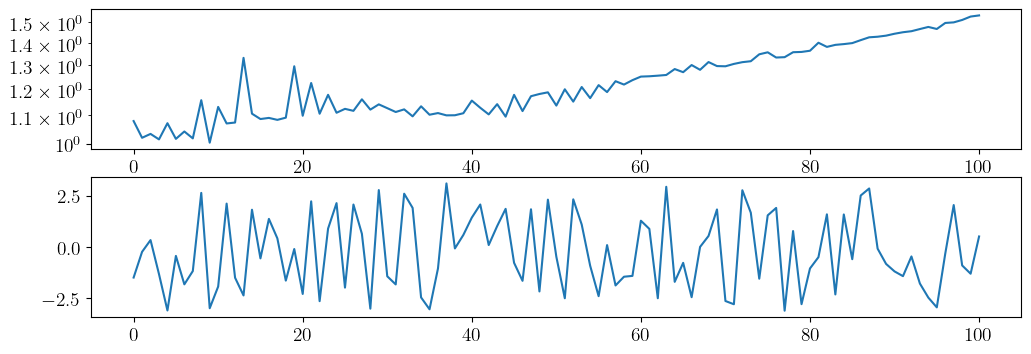

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12,4))

ax[0].semilogy(mag)
ax[1].plot(phase)

<h3>Waveforms</h3>

In [34]:
# start the generators
red.align_channels_phase()
red.OUT_trigger()

In [35]:
# settings
# gen 1
red.OUT1_amplitude(0.1)
red.OUT1_frequency(2e6)
red.OUT1_status('ON')

# gen 2
red.OUT2_amplitude(0.1)
red.OUT2_frequency(2e6)
red.OUT2_status('OFF')

In [36]:
# adc
red.ADC_averaging('OFF')
red.ADC_decimation(4)

# trigger
red.ADC_trigger_level(0.0)

In [37]:
# adc parameters
fs = red.FS / red.ADC_decimation()

In [38]:
# problema con la lettura in binario
# se non c'è segnale non triggera?

In [39]:
# acquisition
red.acquisition_length(1)
data = red.IN1()

red.duty_cycle()

107it [00:01, 99.34it/s]                                                                                               


0.00524288

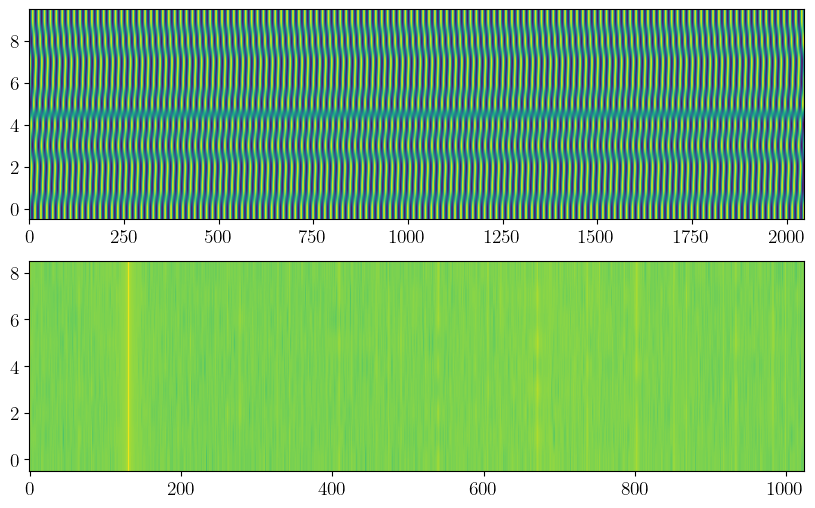

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
n_start = 1
n_stop = 2**11

ax[0].imshow( data[:,n_start:n_stop], aspect='auto', origin='lower' )
ax[1].imshow( np.log10(periodogram( data[:,n_start:n_stop] )[1][1:]), aspect='auto', origin='lower' )

#ax[1].set_ylim([1e-8,1])

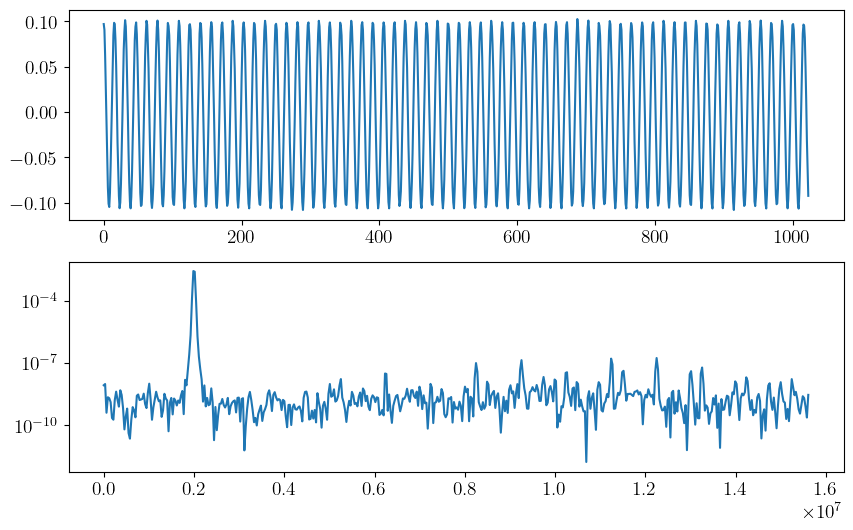

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
n_start = 1
n_stop = 2**10
num = 0

ax[0].plot(data[num, n_start:n_stop])

f = periodogram(data[num, n_start:n_stop], fs=fs)[0]
rbw = f[1] - f[0]
m = rbw * periodogram(data[num, n_start:n_stop], window='hann', fs=fs)[1]
ax[1].semilogy(f, m)

In [42]:
red.estimated_duty_cycle()

0.00524288